#Importing libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Load Dataset

In [5]:
batch_size = 64

In [6]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 22.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 619kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.53MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.46MB/s]


#Visualize Dataset

In [7]:
# 1. Dataset Overview
print(f"Training Samples: {len(train_dataset)}, Test Samples: {len(test_dataset)}")
print(f"Image Shape: {train_dataset[0][0].shape}")

Training Samples: 60000, Test Samples: 10000
Image Shape: torch.Size([1, 28, 28])


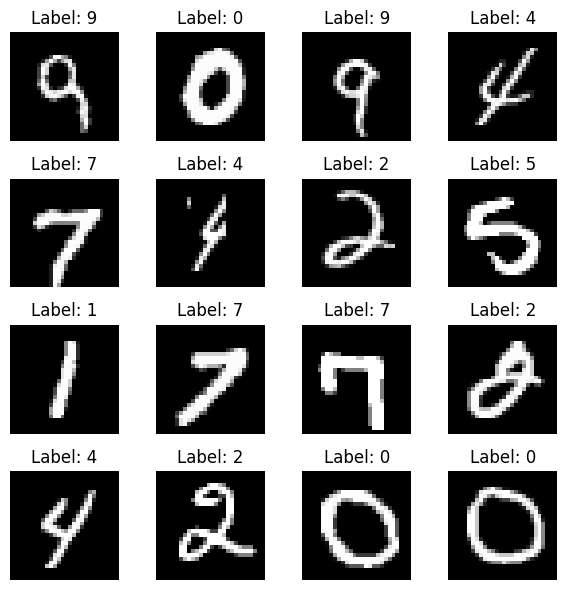

In [8]:
# 2. Visualizing Random MNIST Samples
def plot_samples(dataset, num_samples=16):
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, ax in enumerate(axes.flat):
        img, label = dataset[indices[i]]
        img = img.squeeze().numpy()
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Label: {label}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

plot_samples(train_dataset)

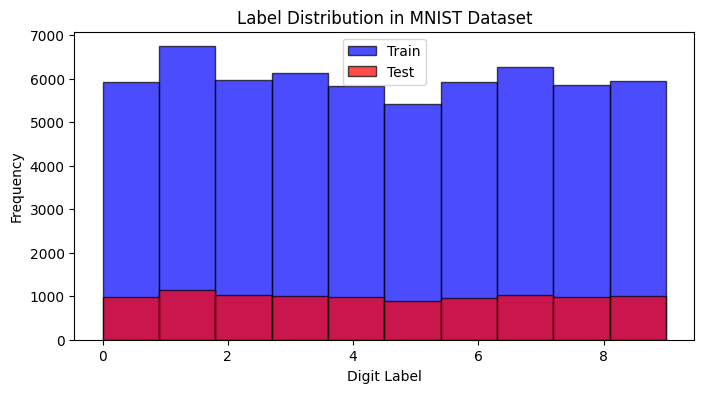

In [9]:
# 3. Distribution of Labels
train_labels = [label for _, label in train_dataset]
test_labels = [label for _, label in test_dataset]

plt.figure(figsize=(8, 4))
plt.hist(train_labels, bins=10, alpha=0.7, label="Train", color='blue', edgecolor='black')
plt.hist(test_labels, bins=10, alpha=0.7, label="Test", color='red', edgecolor='black')
plt.xlabel("Digit Label")
plt.ylabel("Frequency")
plt.title("Label Distribution in MNIST Dataset")
plt.legend()
plt.show()

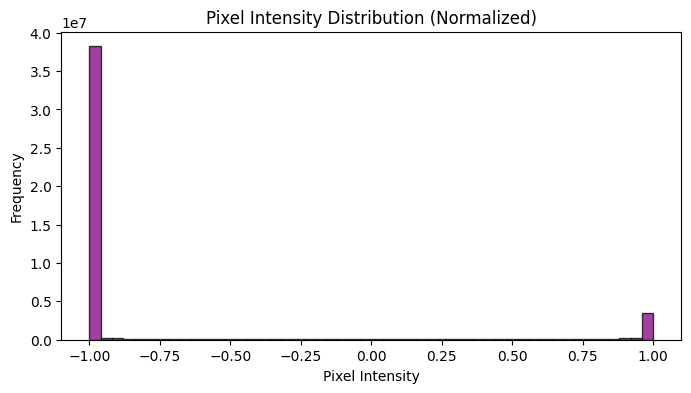

In [10]:
# 4. Pixel Intensity Distribution
train_images = torch.stack([img for img, _ in train_dataset])
pixel_values = train_images.view(-1).numpy()

plt.figure(figsize=(8, 4))
plt.hist(pixel_values, bins=50, color="purple", alpha=0.75, edgecolor="black")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Pixel Intensity Distribution (Normalized)")
plt.show()

#DNN

##Task-1

Activation Functions:

1.1. Implement a simple DNN of your choice with sigmoid, tanh and ReLU activation functions. Show that ReLU fixes the vanishing gradient problem experienced by the previous two. Provide precise and to the point explanation.

1.2. Compare the performance difference (if any) in using the various ReLU variants. (ReLU, Leaky ReLU, Parametric ReLU)



### DNN Architecture

In [11]:
class SimpleDNN(nn.Module):
    def __init__(self, activation_fn):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

        self.activation = activation_fn

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
def train_model(activation_fn, name):
    model = SimpleDNN(activation_fn).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    losses = []
    accuracies = []
    avg_gradients = []

    for epoch in range(10):
        running_loss = 0.0
        correct = 0
        total = 0
        total_grad = 0
        count = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            total_grad += sum(p.grad.abs().mean().item() for p in model.parameters() if p.grad is not None)
            count += 1

            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        losses.append(running_loss / len(train_loader))
        accuracies.append(100 * correct / total)
        avg_gradients.append(total_grad / count)
        print(f"{name} - Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    return losses, accuracies, avg_gradients

In [15]:
activations = {
    "Sigmoid": nn.Sigmoid(),
    "Tanh": nn.Tanh(),
    "ReLU": nn.ReLU(),
    "Leaky ReLU": nn.LeakyReLU(negative_slope=0.01),
    "Parametric ReLU": nn.PReLU()
}


### Training

In [16]:
loss_results = {}
accuracies = {}
grad_results = {}

for name, activation in activations.items():
    print(f"\nTraining with {name} activation...")
    loss_results[name],accuracies[name], grad_results[name] = train_model(activation, name)



Training with Sigmoid activation...
Sigmoid - Epoch 1, Loss: 1.4257, Accuracy: 53.93%
Sigmoid - Epoch 2, Loss: 0.4449, Accuracy: 87.14%
Sigmoid - Epoch 3, Loss: 0.3387, Accuracy: 90.13%
Sigmoid - Epoch 4, Loss: 0.2869, Accuracy: 91.67%
Sigmoid - Epoch 5, Loss: 0.2485, Accuracy: 92.83%
Sigmoid - Epoch 6, Loss: 0.2172, Accuracy: 93.75%
Sigmoid - Epoch 7, Loss: 0.1913, Accuracy: 94.53%
Sigmoid - Epoch 8, Loss: 0.1707, Accuracy: 95.06%
Sigmoid - Epoch 9, Loss: 0.1540, Accuracy: 95.53%
Sigmoid - Epoch 10, Loss: 0.1407, Accuracy: 95.96%

Training with Tanh activation...
Tanh - Epoch 1, Loss: 0.3942, Accuracy: 88.42%
Tanh - Epoch 2, Loss: 0.1804, Accuracy: 94.60%
Tanh - Epoch 3, Loss: 0.1304, Accuracy: 96.11%
Tanh - Epoch 4, Loss: 0.1009, Accuracy: 97.00%
Tanh - Epoch 5, Loss: 0.0825, Accuracy: 97.50%
Tanh - Epoch 6, Loss: 0.0698, Accuracy: 97.80%
Tanh - Epoch 7, Loss: 0.0593, Accuracy: 98.18%
Tanh - Epoch 8, Loss: 0.0505, Accuracy: 98.42%
Tanh - Epoch 9, Loss: 0.0425, Accuracy: 98.69%
Tanh 

### Result Visualization

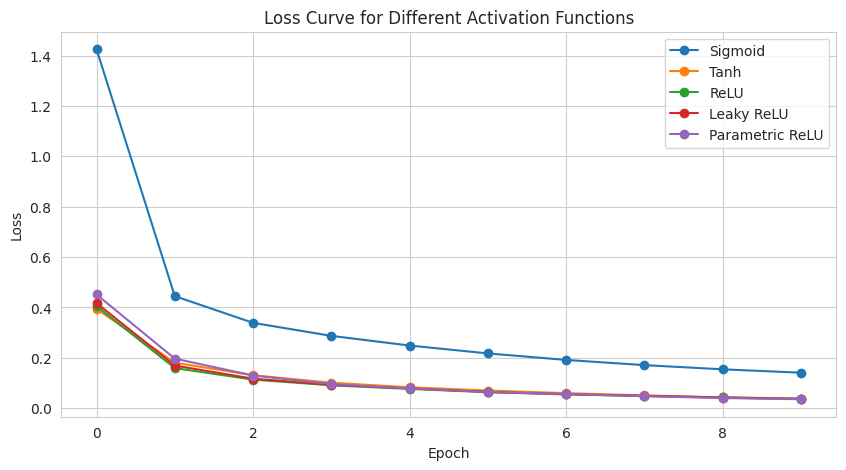

In [17]:
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(10, 5))
for name, losses in loss_results.items():
    plt.plot(losses, marker='o', linestyle='-', label=name)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve for Different Activation Functions")
plt.legend()
plt.grid(True)
plt.show()


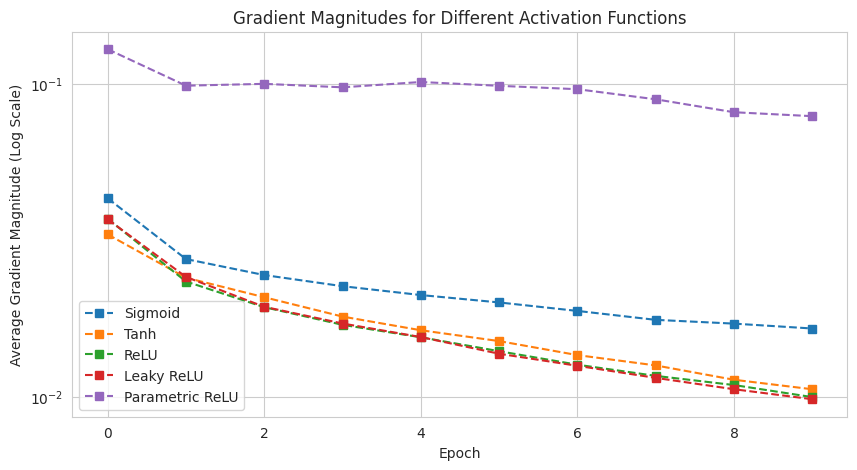

In [18]:
plt.figure(figsize=(10, 5))
for name, grads in grad_results.items():
    plt.plot(grads, marker='s', linestyle='--', label=name)
plt.xlabel("Epoch")
plt.ylabel("Average Gradient Magnitude (Log Scale)")
plt.yscale("log")
plt.title("Gradient Magnitudes for Different Activation Functions")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
from torchsummary import summary

model = SimpleDNN(nn.ReLU()).to(device)
summary(model, (1, 28*28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 128]          32,896
              ReLU-4                  [-1, 128]               0
            Linear-5                   [-1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


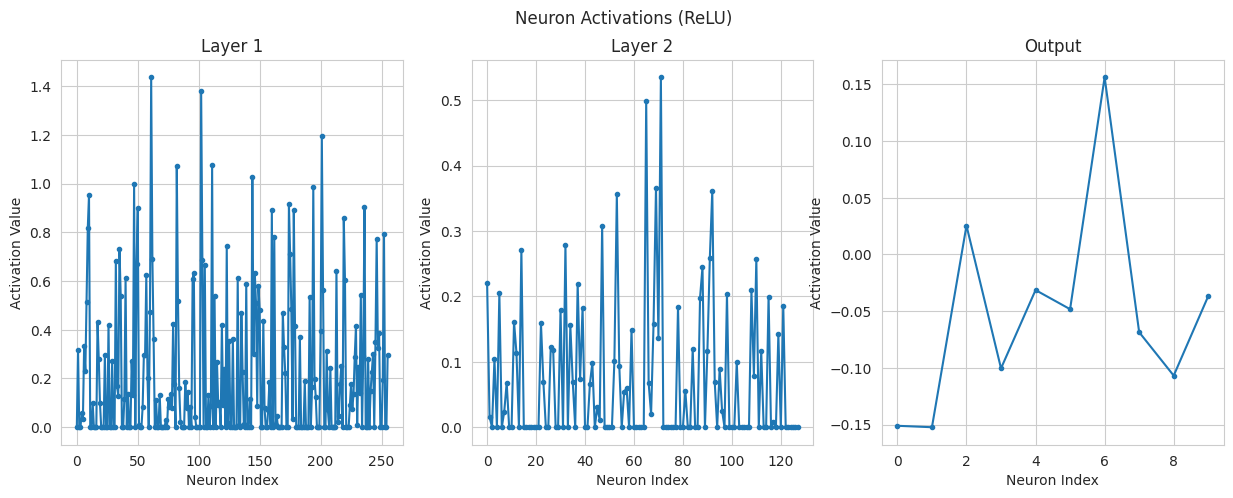

In [20]:
def visualize_activations(model, activation_fn):
    model.eval()
    images, _ = next(iter(train_loader))
    images = images.to(device)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    layer_names = ["Layer 1", "Layer 2", "Output"]

    with torch.no_grad():
        x = images.view(-1, 28*28)
        for i, layer in enumerate([model.fc1, model.fc2, model.fc3]):
            x = activation_fn(layer(x)) if i < 2 else layer(x)

            axs[i].plot(x.cpu().numpy()[0], marker='o', linestyle='-', markersize=3)
            axs[i].set_title(layer_names[i])
            axs[i].set_xlabel("Neuron Index")
            axs[i].set_ylabel("Activation Value")
            axs[i].grid(True)

    plt.suptitle(f"Neuron Activations ({activation_fn.__class__.__name__})")
    plt.show()

visualize_activations(model, nn.ReLU())


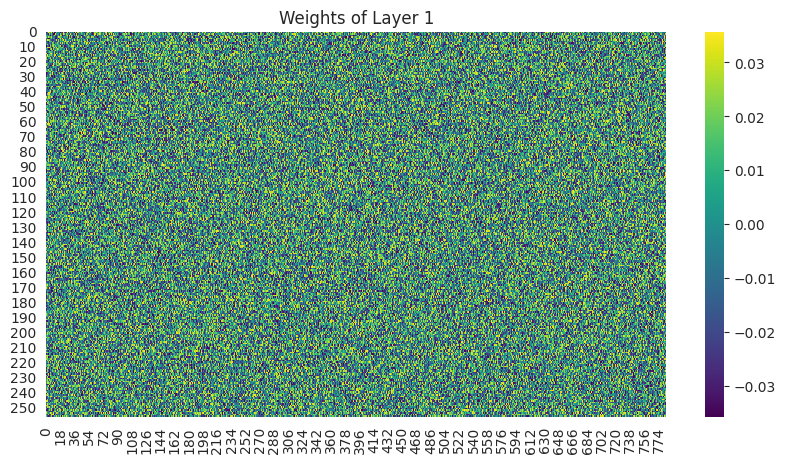

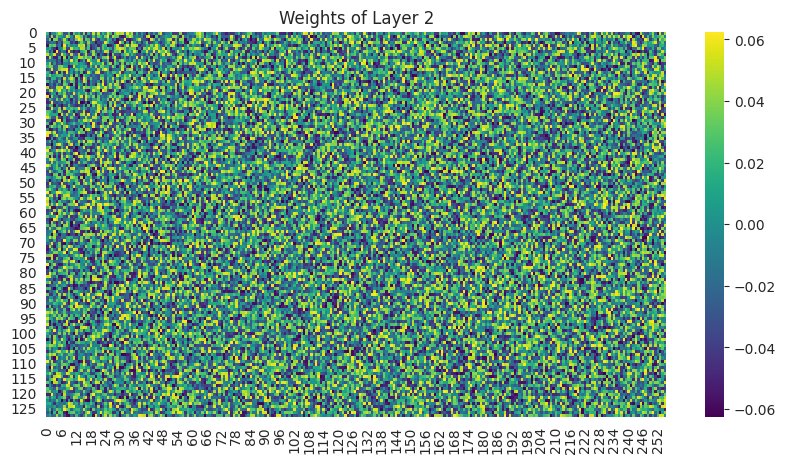

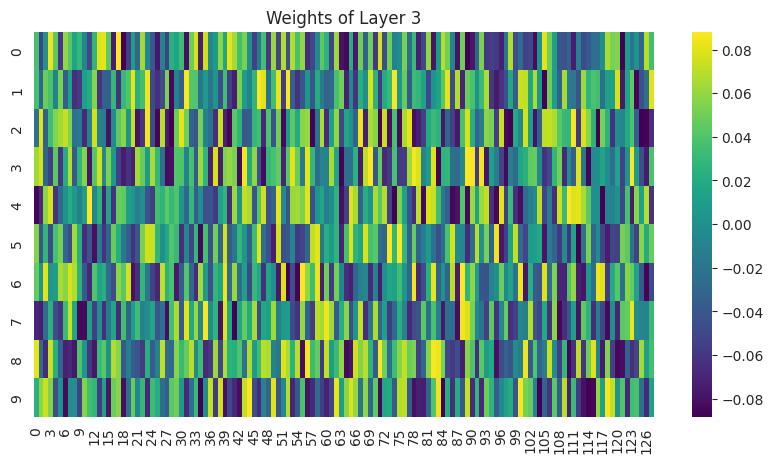

In [ ]:
import seaborn as sns

def plot_weights(model):
    for i, layer in enumerate([model.fc1, model.fc2, model.fc3]):
        weights = layer.weight.data.cpu().numpy()
        plt.figure(figsize=(10, 5))
        sns.heatmap(weights, cmap="viridis", center=0)
        plt.title(f"Weights of Layer {i+1}")
        plt.show()

plot_weights(model)


##Task-2

Depth of ANNs:

2.1. Appreciate the role of depth by trying different depth implementations of artificial neural networks. Try at least               five different depths. Use plots to support your argument. Test accuracies or loss could be plotted against depth.

### DNN Architecture

In [21]:
def create_dnn(depth, activation_fn):
    layers = []
    input_size = 28 * 28
    output_size = 10

    for i in range(depth):
        layers.append(nn.Linear(input_size if i == 0 else 128, 128))
        layers.append(activation_fn())

    layers.append(nn.Linear(128, output_size))

    model = nn.Sequential(*layers)
    return model

In [24]:
def train_model_with_depth(depth, activation_fn, epochs=10):
    model = create_dnn(depth, activation_fn).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    train_loss = []
    train_accuracy = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images.view(-1, 28*28))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss.append(running_loss / len(train_loader))
        train_accuracy.append(100 * correct / total)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    return train_loss, train_accuracy

### Training with dataset

In [28]:
depths = [2,3,5,7,9]

losses = {}
accuracies = {}

for depth in depths:
    print(f"\nTraining model with depth {depth}...")
    losses[depth], accuracies[depth] = train_model_with_depth(depth, nn.ReLU, epochs=10)



Training model with depth 2...
Epoch [1/10], Loss: 0.4161, Accuracy: 87.50%
Epoch [2/10], Loss: 0.1749, Accuracy: 94.65%
Epoch [3/10], Loss: 0.1271, Accuracy: 96.06%
Epoch [4/10], Loss: 0.0999, Accuracy: 96.94%
Epoch [5/10], Loss: 0.0830, Accuracy: 97.40%
Epoch [6/10], Loss: 0.0726, Accuracy: 97.65%
Epoch [7/10], Loss: 0.0644, Accuracy: 97.87%
Epoch [8/10], Loss: 0.0553, Accuracy: 98.20%
Epoch [9/10], Loss: 0.0498, Accuracy: 98.35%
Epoch [10/10], Loss: 0.0447, Accuracy: 98.50%

Training model with depth 3...
Epoch [1/10], Loss: 0.4988, Accuracy: 84.08%
Epoch [2/10], Loss: 0.1800, Accuracy: 94.51%
Epoch [3/10], Loss: 0.1300, Accuracy: 96.00%
Epoch [4/10], Loss: 0.1051, Accuracy: 96.73%
Epoch [5/10], Loss: 0.0876, Accuracy: 97.27%
Epoch [6/10], Loss: 0.0754, Accuracy: 97.58%
Epoch [7/10], Loss: 0.0677, Accuracy: 97.85%
Epoch [8/10], Loss: 0.0595, Accuracy: 98.02%
Epoch [9/10], Loss: 0.0503, Accuracy: 98.37%
Epoch [10/10], Loss: 0.0460, Accuracy: 98.48%

Training model with depth 5...
Ep

### Depth Comparision Visualizations

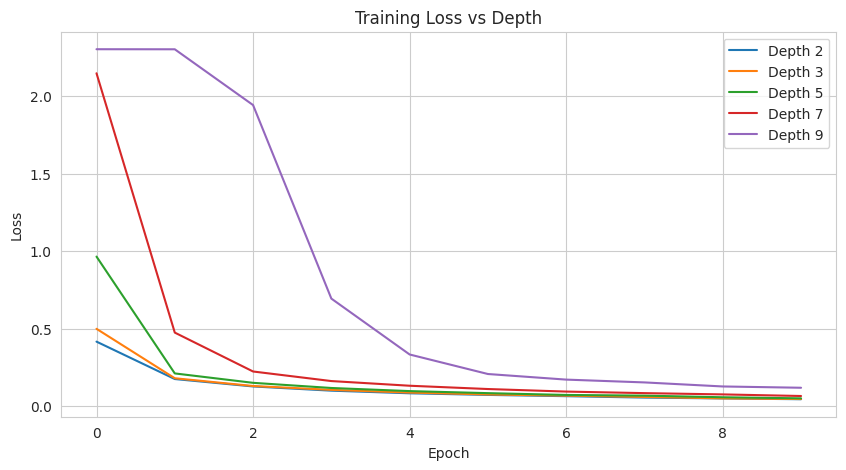

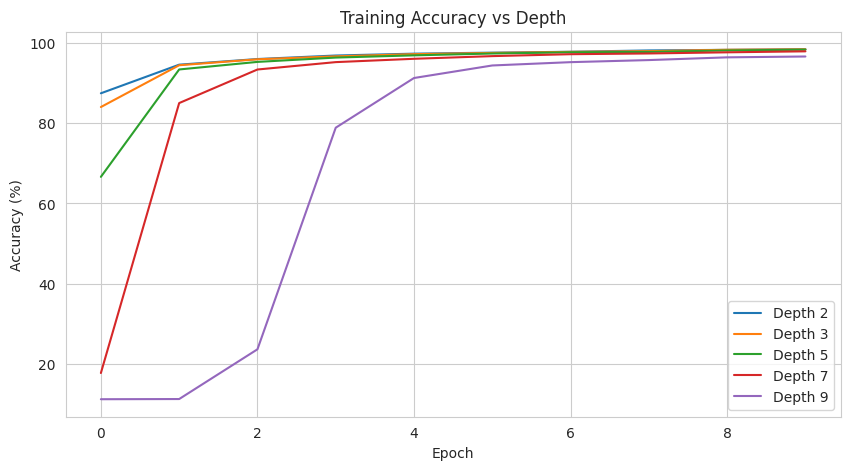

In [29]:
plt.figure(figsize=(10, 5))
for depth in depths:
    plt.plot(losses[depth], label=f"Depth {depth}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Depth")
plt.legend()
plt.show()

# Plot accuracy vs depth
plt.figure(figsize=(10, 5))
for depth in depths:
    plt.plot(accuracies[depth], label=f"Depth {depth}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy vs Depth")
plt.legend()
plt.show()